## Pix2Pix Training 
Implementation based on https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
Developed by David Dória https://github.com/daversd for
2021-2022 B-pro Architectural Design RC4

Pix2Pix is a conditional genrative adversarial network model that performs image-to-image translations, learning how to do this operation from a data set of image pairs (input and expected outputs). This implementation uses `256x256 px` images for input and output, expecting training set to be formatted already in a folder that contains `/AB/train/` and `AB/test/`.

### Import the required packages

In [1]:
import torch
import torch.onnx
from torch.utils.tensorboard import SummaryWriter
import pix2pix_helpers.util as util
from pix2pix_helpers.create_dataset import ImageFolderLoader
from pix2pix_helpers.pix2pix_model import Pix2PixModel
from matplotlib import pyplot as plt
import time
import os
import glob

### High level setup
Important notes:
- Use a training set that is at least on the hundreds figure to have a realiable result. The more, the better
- If you are doing multiple instances of training, and you would like to keep track of the different results of each instance of training, remember to update the value of `MODEL_NAME`. Otherwise, the data produced previously will be overwritten.
- 300 epochs is a good number. If you use more epochs, ensure you keep track of the training outputs to check if your model is not overfitting.

In [2]:
TRAIN = True             # Determines if the program must enter training mode
TEST = True             # Determines if the program must enter testing mode (loads the latest checkpoint)
TEST_SAMPLE = 10         # The number of samples for testing mode
WRITE_LOGS = True       # Determines if tensorboard logs should be written to disk
SAVE_CKPTS = True       # Determines if checkpoints should be saved
SAVE_IMG_CKPT = True    # Determines if images should be saved for each checkpoint
EXPORT_MODEL = True     # Determines if the model should be exported (loads the latest checkpoint)

FOLDER_NAME = 'data/tracos'                            # The name of the data folder
MODEL_NAME = 'tracos_run_1'                            # The name of the model for this run
LOAD_NUMBER = -1                                        # Number of the model to be loaded (-1 loads the latest)
CKPT_DIR = os.path.join('checkpoints', MODEL_NAME)      # The folder to save checkpoints to
LOG_DIR = 'runs/' + MODEL_NAME                          # The folder to save tensorboard logs to
TEST_DIR = 'test/' + MODEL_NAME                         # The folder to save test images to

BATCH_SIZE = 1
EPOCHS = 500                # Will be split in two parts, must be even

PRINT_FREQ = 100            # Interval of steps between print logs
LOG_FREQ = 100              # Interval of steps between tensorboard logs
CKPT_FREQ = 10              # Interval of epochs between checkpoints

### Finish setup and create folders

In [3]:
# Create the required folders
if SAVE_CKPTS:
    if not os.path.isdir(CKPT_DIR):
        os.makedirs(CKPT_DIR)

if WRITE_LOGS:
    if not os.path.isdir(LOG_DIR):
        os.makedirs(LOG_DIR)

if SAVE_IMG_CKPT:
    if not os.path.isdir(TEST_DIR):
        os.makedirs(TEST_DIR)

# Initialize the log writer
if WRITE_LOGS:
    writer = SummaryWriter(log_dir=LOG_DIR)

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Create a function to load saved models

In [4]:
def load_model(model):
    """
    Loads the networks from the checkpoint specified in LOAD_NUMBER
    Use -1 to load the latest model.
    """
    
    list_of_files = glob.glob(CKPT_DIR + '/*.pth')

    if LOAD_NUMBER == -1:
        file_path = max(list_of_files, key=os.path.getctime)
        file_name = os.path.basename(file_path)
        file_number = file_name.split('_')[0]
        print(file_number)
    else:
        file_number = LOAD_NUMBER
    
    file_prefix = os.path.join(CKPT_DIR, str(file_number) + '_')
    netG_File = file_prefix + 'net_G.pth'
    netD_File = file_prefix + 'net_D.pth'
    
    files_exist = os.path.exists(netG_File) and os.path.exists(netD_File)
    assert files_exist, f"Checkpoint {LOAD_NUMBER} does not exist. Check '{CKPT_DIR}' to see available checkpoints"
    print(f"Loading model from checkpoint {file_number} \n"+ f"Generator is {netG_File} \n" + f"Discriminator is {netD_File}")

    model.load_networks(file_number)


### Main program
Train the discriminator and generator for `EPOCHS` using the training data that is present on `FOLDER_NAME`. Checkpoints are saved to `CKPT_DIR`, training status is printed to the console and saved to the writer (if defined so).

---------- Networks initialized -------------
[Network G] Total number of parameters : 54.414 M
[Network D] Total number of parameters : 1.716 M
Step 100 | Epoch 0 | GAN Loss: 1.482 | Gen. L1: 16.954 | Disc. real: 0.412 | Disc. fake: 0.578
Saving the model at the end of epoch 0, iters 191
Saving current epoch test to test folder
End of epoch 0 / 499 	 Time Taken: 15 secs
Step 200 | Epoch 1 | GAN Loss: 1.975 | Gen. L1: 50.485 | Disc. real: 0.036 | Disc. fake: 0.337
Step 300 | Epoch 1 | GAN Loss: 1.091 | Gen. L1: 9.468 | Disc. real: 1.134 | Disc. fake: 0.306
End of epoch 1 / 499 	 Time Taken: 10 secs
Step 400 | Epoch 2 | GAN Loss: 1.177 | Gen. L1: 17.910 | Disc. real: 0.920 | Disc. fake: 0.285
Step 500 | Epoch 2 | GAN Loss: 1.204 | Gen. L1: 11.245 | Disc. real: 1.645 | Disc. fake: 0.194
End of epoch 2 / 499 	 Time Taken: 10 secs
Step 600 | Epoch 3 | GAN Loss: 1.051 | Gen. L1: 10.550 | Disc. real: 0.545 | Disc. fake: 0.581
Step 700 | Epoch 3 | GAN Loss: 1.186 | Gen. L1: 10.604 | Disc. rea

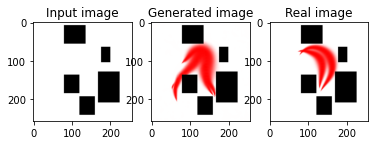

In [5]:
if TRAIN:
    # Create the training data set
    trainData = ImageFolderLoader(
        f"{FOLDER_NAME}/AB", phase='train', preprocess='none')
    trainSet = torch.utils.data.DataLoader(
        trainData, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

    # Create the pix2pix model
    model = Pix2PixModel(CKPT_DIR, MODEL_NAME, is_train=True,
                         n_epochs=EPOCHS/2, n_epochs_decay=EPOCHS/2)

    model.setup()
    total_iters = 0

    # Initiate the training iteration
    for epoch in range(EPOCHS):
        epoch_start_time = time.time()
        iter_data_time = time.time()
        epoch_iter = 0

        if epoch != 0:
            model.update_learning_rate()

        # Iterate through the data batches in the training set
        for i, data in enumerate(trainSet):
            iter_start_time = time.time()

            # Setup counters
            total_iters += BATCH_SIZE
            epoch_iter += BATCH_SIZE

            # Feed input through model, optimize parameters
            model.set_input(data)
            model.optimize_parameters()

            # Use this for logging losses in tensorboard
            if total_iters % PRINT_FREQ == 0:
                losses = model.get_current_losses()
                t_comp = (time.time() - iter_start_time) / BATCH_SIZE
                print(
                    f'Step {total_iters} | Epoch {epoch} | GAN Loss: {losses["G_GAN"]:.3f} | Gen. L1: {losses["G_L1"]:.3f} | Disc. real: {losses["D_real"]:.3f} | Disc. fake: {losses["D_fake"]:.3f}')

            # Use this to log to tensorboard
            if WRITE_LOGS and total_iters % LOG_FREQ == 0:
                losses = model.get_current_losses().items()
                for name, loss in losses:
                    writer.add_scalar(name, loss, total_iters)  # type: ignore
                writer.close()  # type: ignore

            iter_data_time = time.time()

        # Save checkpoints per epochs
        if SAVE_CKPTS and epoch % CKPT_FREQ == 0:
            print('Saving the model at the end of epoch %d, iters %d' %
                  (epoch, total_iters))
            model.save_network(epoch)

            # Save image per checkpoint
            if SAVE_IMG_CKPT:
                print('Saving current epoch test to test folder')
                visuals = model.get_current_visuals()
                save_path = os.path.join(
                    TEST_DIR, 'epoch_' + str(epoch) + '.jpg')
                util.save_visuals(visuals, save_path)

        # Print details at the end of the epoch
        print('End of epoch %d / %d \t Time Taken: %d secs' %
              (epoch, EPOCHS -1, time.time() - epoch_start_time))

    # Save / overwrite final epoch and image
    if SAVE_CKPTS:
        print('Saving the model at the end of training')
        model.save_network(epoch)

        if SAVE_IMG_CKPT:
            print('Saving final epoch test to test folder')
            visuals = model.get_current_visuals()
            save_path = os.path.join(TEST_DIR, 'epoch_' + str(epoch) + '.jpg')
            util.save_visuals(visuals, save_path)

    # Plot last visuals from the model once training is complete
    visuals = model.get_current_visuals()
    util.plot_visuals(visuals)


### Test the model
Generate a batch of images, defined by `TEST_SAMPLE`, using the images that are on its `test` folder. It loads the model from the checkpoint defined by `LOAD_NUMBER`. The generated images are saved to `TEST_DIR`.

In [ ]:
if TEST:
        # Create the testing data set
        testData = ImageFolderLoader(f'{FOLDER_NAME}/AB', phase='test', flip=False, preprocess='none')
        testSet = torch.utils.data.DataLoader(testData, batch_size=BATCH_SIZE, shuffle= False, num_workers=0)

        # Create the pix2pix model in testing mode
        model = Pix2PixModel(CKPT_DIR, MODEL_NAME, is_train=False, n_epochs=EPOCHS/2, n_epochs_decay=EPOCHS/2)
        model.setup()
        model.eval()
        load_model(model)

        # Iterate through test data set, for the lenght of the test sample
        for i, data in enumerate(testSet):
            if i < TEST_SAMPLE:
                model.set_input(data)
                model.test()
                visuals = model.get_current_visuals()
                save_path = os.path.join(TEST_DIR, 'test_' + str(i) + '.jpg')
                util.save_visuals(visuals, save_path)
            else:
                break

### Export the Model
In order to use the model outside this training setup, you need to export it. An exported model in the `.onnx` format can be used by Unity using its `Barracuda` package.

In [ ]:
if EXPORT_MODEL:
        # Create dummy input
        x = torch.randn(1, 3, 256, 256)

        # Create the model and load the latest checkpoint
        model = Pix2PixModel(CKPT_DIR, MODEL_NAME, is_train=False, n_epochs=EPOCHS/2, n_epochs_decay=EPOCHS/2)
        model.setup()
        model.eval()
        load_model(model)

        if not os.path.isdir('exported'):
            os.makedirs('exported')
        
        path = os.path.join('exported', f'{MODEL_NAME}.onnx')
        f = open(path, 'w+')

        torch.onnx.export(model.netG, x.to(DEVICE), path, training=torch.onnx.TrainingMode.EVAL, export_params=True, opset_version=10)